In [4]:
import json

import bz2
import regex
from tqdm.auto import tqdm
from scipy import sparse
from pymystem3 import Mystem

In [5]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

#  Домашнее задание по NLP # 1 [100 баллов]
## Классификация по тональности 

В этом домашнем задании вам предстоит классифицировать по тональности отзывы на банки с сайта banki.ru.

Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5. 

Тексты хранятся в json-ах в массиве responses.

Посмотрим на пример отзыва:

In [4]:
responses[99]

{'city': 'г. Саратов',
 'rating_not_checked': False,
 'title': 'Карта ко вкладу',
 'num_comments': 0,
 'bank_license': 'лицензия № 880',
 'author': 'ronnichka',
 'bank_name': 'Югра',
 'datetime': '2015-06-03 20:56:57',
 'text': 'Здравствуйте! Хотела написать, что мне месяц не выдают карту ко вкладу, ссылаясь на "нам же их из Самары везут" (на секундочку 5 часов езды от нашего города). Но! Прочитала, что людям 3,5 месяцев не выдают карту, и поняла, что у меня все хорошо, пока что. И подарок мне дали, и кулер в отделении есть. Так что я, конечно, готова ждать. Правда хотелось бы не очень долго.',
 'rating_grade': 3}

## Часть 1. Анализ текстов [40/100]

1. Посчитайте количество отзывов в разных городах и на разные банки
2. Постройте гистограмы длин слов в символах и в словах
3. Найдите 10 самых частых:
    * слов
    * слов без стоп-слов
    * лемм 
* существительных
4. Постройте кривые Ципфа и Хипса
5. Ответьте на следующие вопросы:
    * какое слово встречается чаще, "сотрудник" или "клиент"?
    * сколько раз встречается слова "мошенничество" и "доверие"?
6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

## 1.1 - Количество отзывов в разных городах и банках
Посчитайте количество отзывов в разных городах и на разные банки

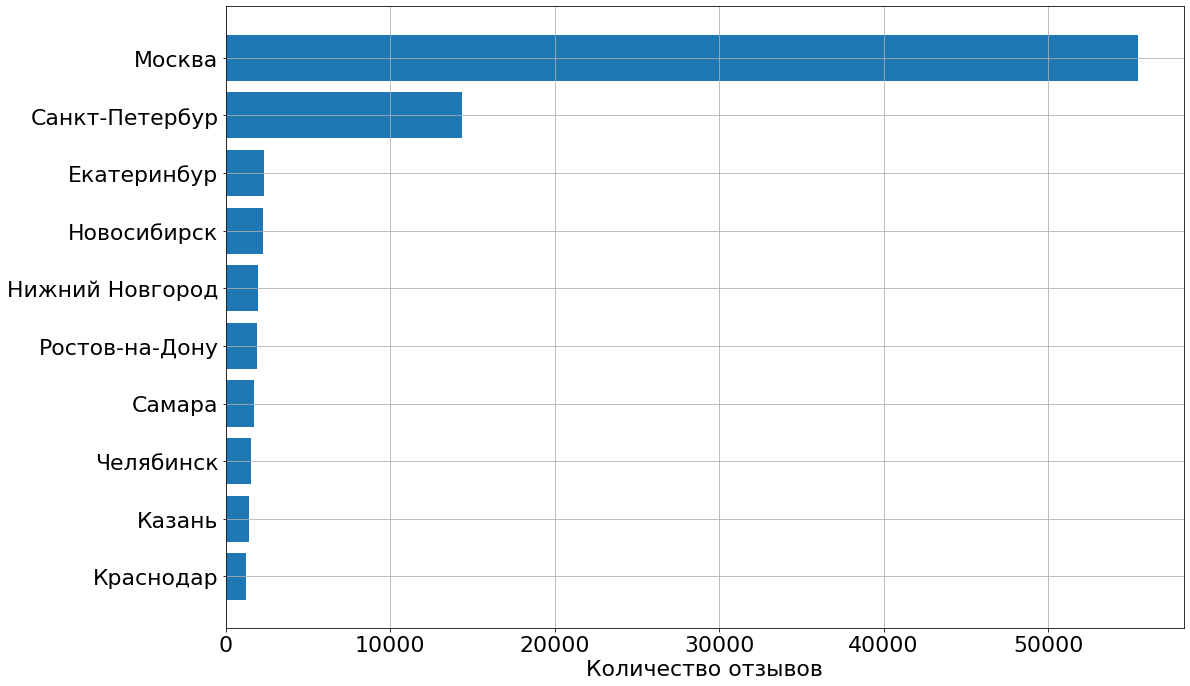

In [26]:
plt.figure(figsize=(17,10))
plt.rcParams.update({'font.size':22})

top_size = 10
city_responses = sorted(Counter([x['city'].strip('г. ') for x in responses if x['city']]).items(), 
                        key=lambda x: -x[1])[:top_size]

plt.barh([x[0] for x in city_responses][::-1],[x[1] for x in city_responses][::-1])
plt.xlabel('Количество отзывов')
plt.grid()
plt.tight_layout()

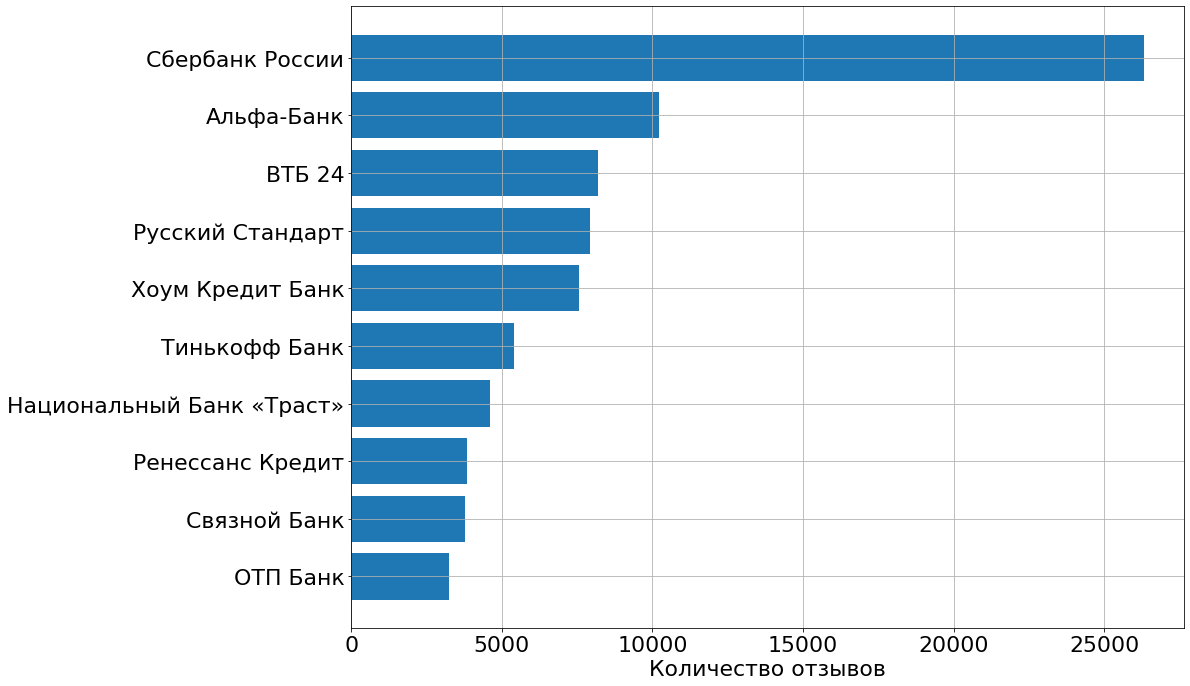

In [29]:
plt.figure(figsize=(17,10))
plt.rcParams.update({'font.size':22})

top_size = 10
bank_responses = sorted(Counter([x['bank_name'] for x in responses]).items(), key=lambda x: -x[1])[:top_size]

plt.barh([x[0] for x in bank_responses][::-1],[x[1] for x in bank_responses][::-1])
plt.xlabel('Количество отзывов')
plt.grid()
plt.tight_layout()

## 1.2 - Гистограммы длин слов
Постройте гистограмы длин слов в символах и в словах

In [33]:
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')

class RussianTokenizer(object):
    def __init__(self, process=False, remove_stop_words=False, stem=False):
        self.russian_pattern = re.compile("[а-яА-Яa-zA-Z]+")
        self.stop_words = {*stopwords.words('english'),
                           *stopwords.words('russian')}
        self.process = process
        self.remove_stop_words = remove_stop_words
        self.stem = stem
        self.stemmer = Mystem()

    def tokenize(self, text, lowercase=True):
        if self.process:
            text = text.replace('-', ' ')
        if lowercase: text = text.lower()
        if self.stem: 
            tokens = self.stemmer.lemmatize(text)
        else:
            tokens = nltk.word_tokenize(text, language='russian')
        
        if self.process:
            return [self._remove_duplicate_characters(tok) for tok in 
                    filter(self.russian_pattern.match, tokens) if self._is_valid(tok)]
        else:
            return [tok for tok in filter(self.russian_pattern.match, tokens)]

    @staticmethod
    def _remove_duplicate_characters(text):
        # добавлено после анализа токенов в этом упражнении
        return re.sub(r'([а-яА-Яa-zA-Z])\1+', r'\1', text)

    def _is_valid(self, token):
        # добавлено после анализа токенов в этом упражнении
        return all([
            '/' not in token,
            'descr=' not in token.lower(),
            'счет:' not in token.lower(),
            'resid=' not in token.lower(),
            len(token) > 1 or token.lower() in self.stop_words,
            not self.remove_stop_words or token.lower() not in self.stop_words
        ])


tokenizer = RussianTokenizer()
    
words = []
for resp in tqdm(responses[:1000]):
    for word in tokenizer.tokenize(resp['text']):
        words.append(word)

[nltk_data] Downloading package punkt to /home/artem/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


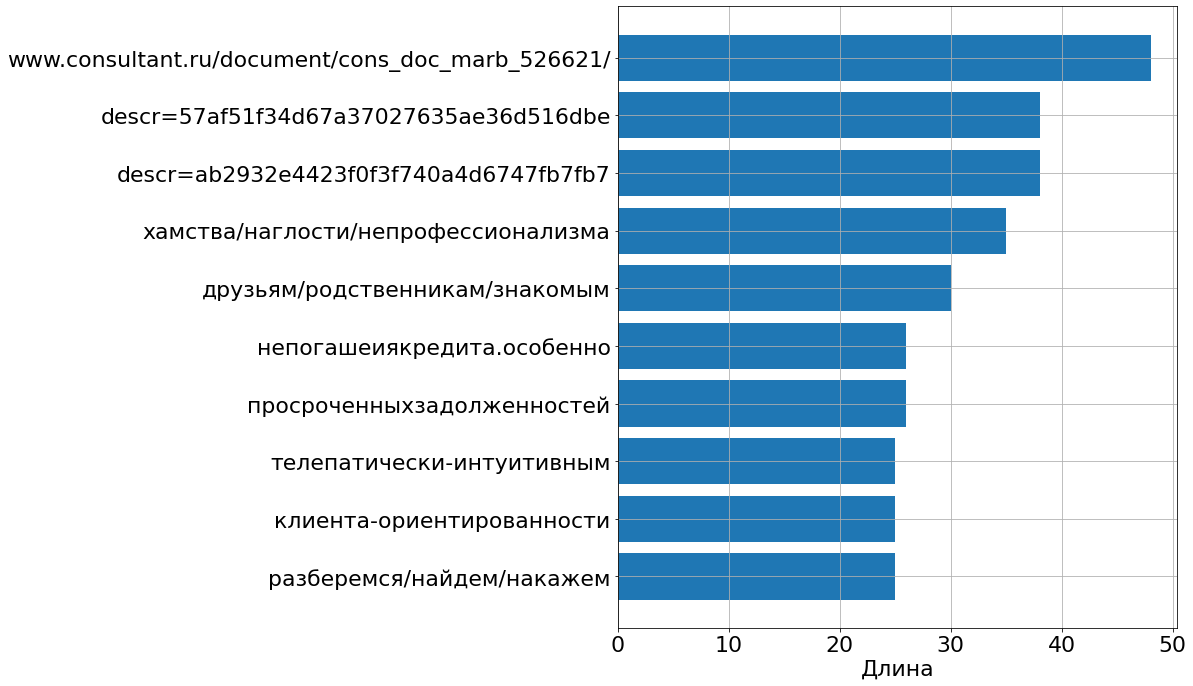

In [129]:
plt.figure(figsize=(17,10))
plt.rcParams.update({'font.size':22})

top_size = 10
word_lengths = sorted({w:len(w) for w in set(words)}.items(), key=lambda x: -x[1])[:top_size]

plt.barh([x[0] for x in word_lengths][::-1],[x[1] for x in word_lengths][::-1])
plt.xlabel('Длина')
plt.grid()
plt.tight_layout()

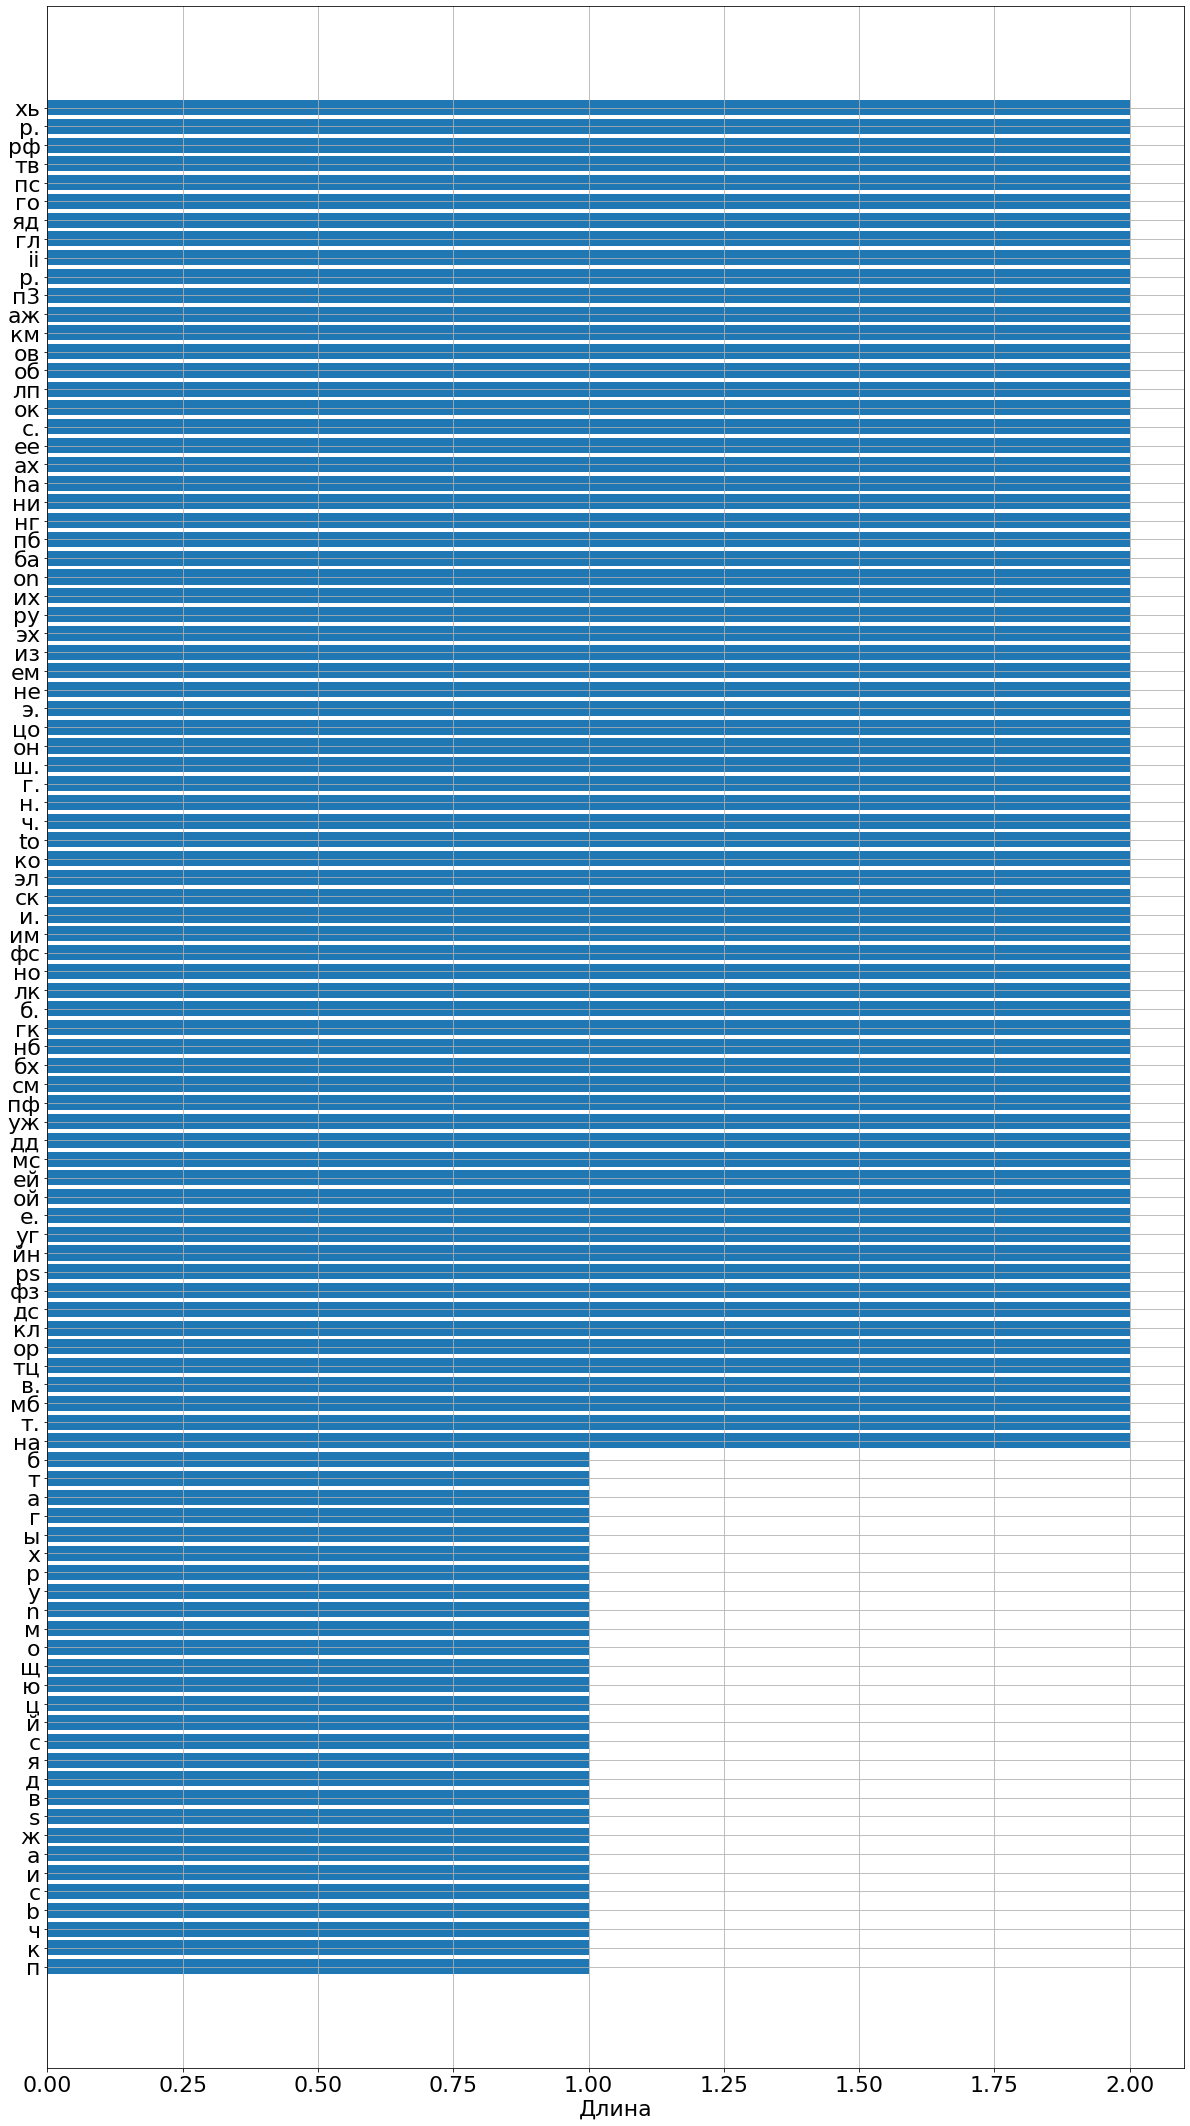

In [130]:
plt.figure(figsize=(17,30))
plt.rcParams.update({'font.size':22})

top_size = 100
word_lengths = sorted({w:len(w) for w in set(words)}.items(), key=lambda x: -x[1])[-top_size:]

plt.barh([x[0] for x in word_lengths][::-1],[x[1] for x in word_lengths][::-1])
plt.xlabel('Длина')
plt.grid()
plt.tight_layout()

Обработаем треш-токены

In [9]:
tokenizer = RussianTokenizer(process=True)
    
tokens = []
for resp in tqdm(responses):
    tokens.append(tokenizer.tokenize(resp['text']))

In [139]:
words = [word for sent in tokens for word in sent]

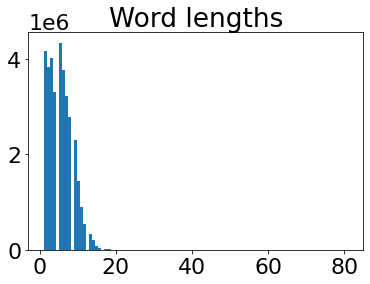

In [279]:
plt.title('Word lengths')
plt.hist(list(map(len, words)), bins=100)
pass

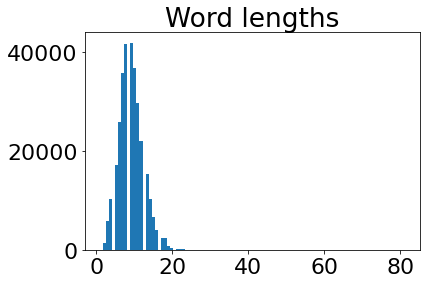

In [280]:
plt.title('Word lengths')
plt.hist(list(map(len, set(words))), bins=100)
pass

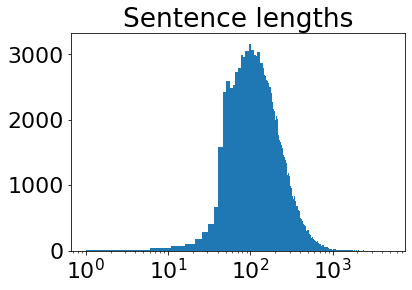

In [275]:
plt.title('Sentence lengths')
plt.hist(list(map(len, tokens)), bins=1000)
plt.xscale('log')
pass

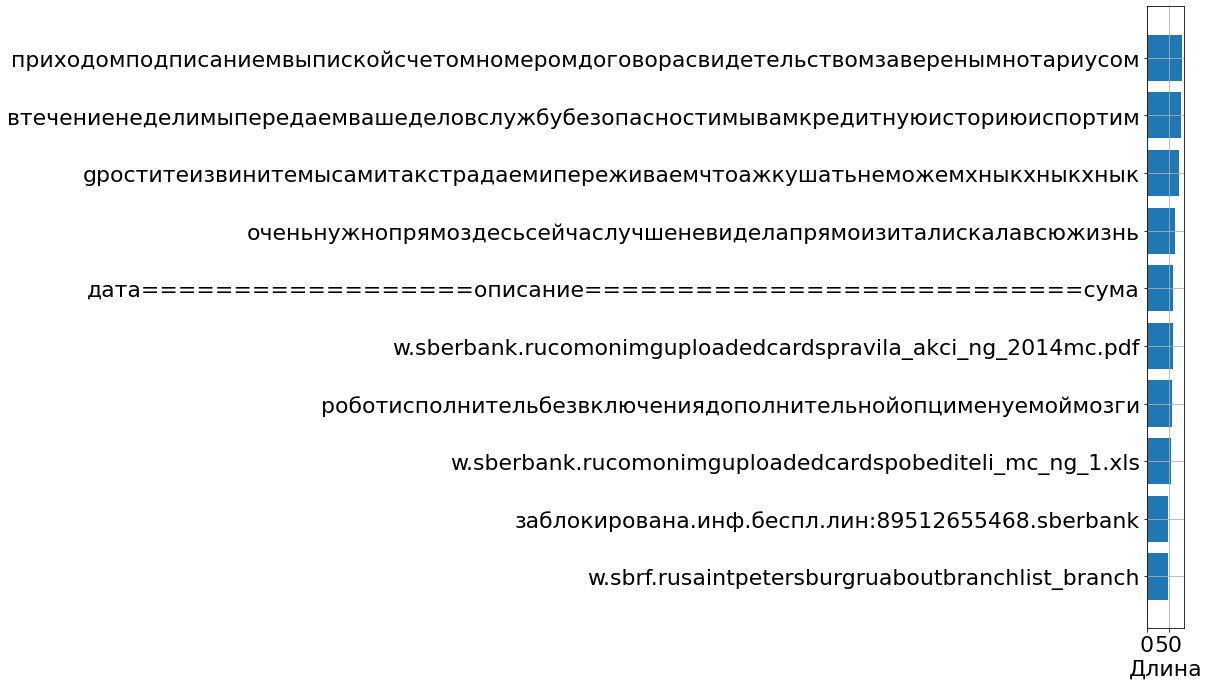

In [140]:
plt.figure(figsize=(17,10))
plt.rcParams.update({'font.size':22})

top_size = 10
word_lengths = sorted({w:len(w) for w in set(words)}.items(), key=lambda x: -x[1])[:top_size]

plt.barh([x[0] for x in word_lengths][::-1],[x[1] for x in word_lengths][::-1])
plt.xlabel('Длина')
plt.grid()
plt.tight_layout()

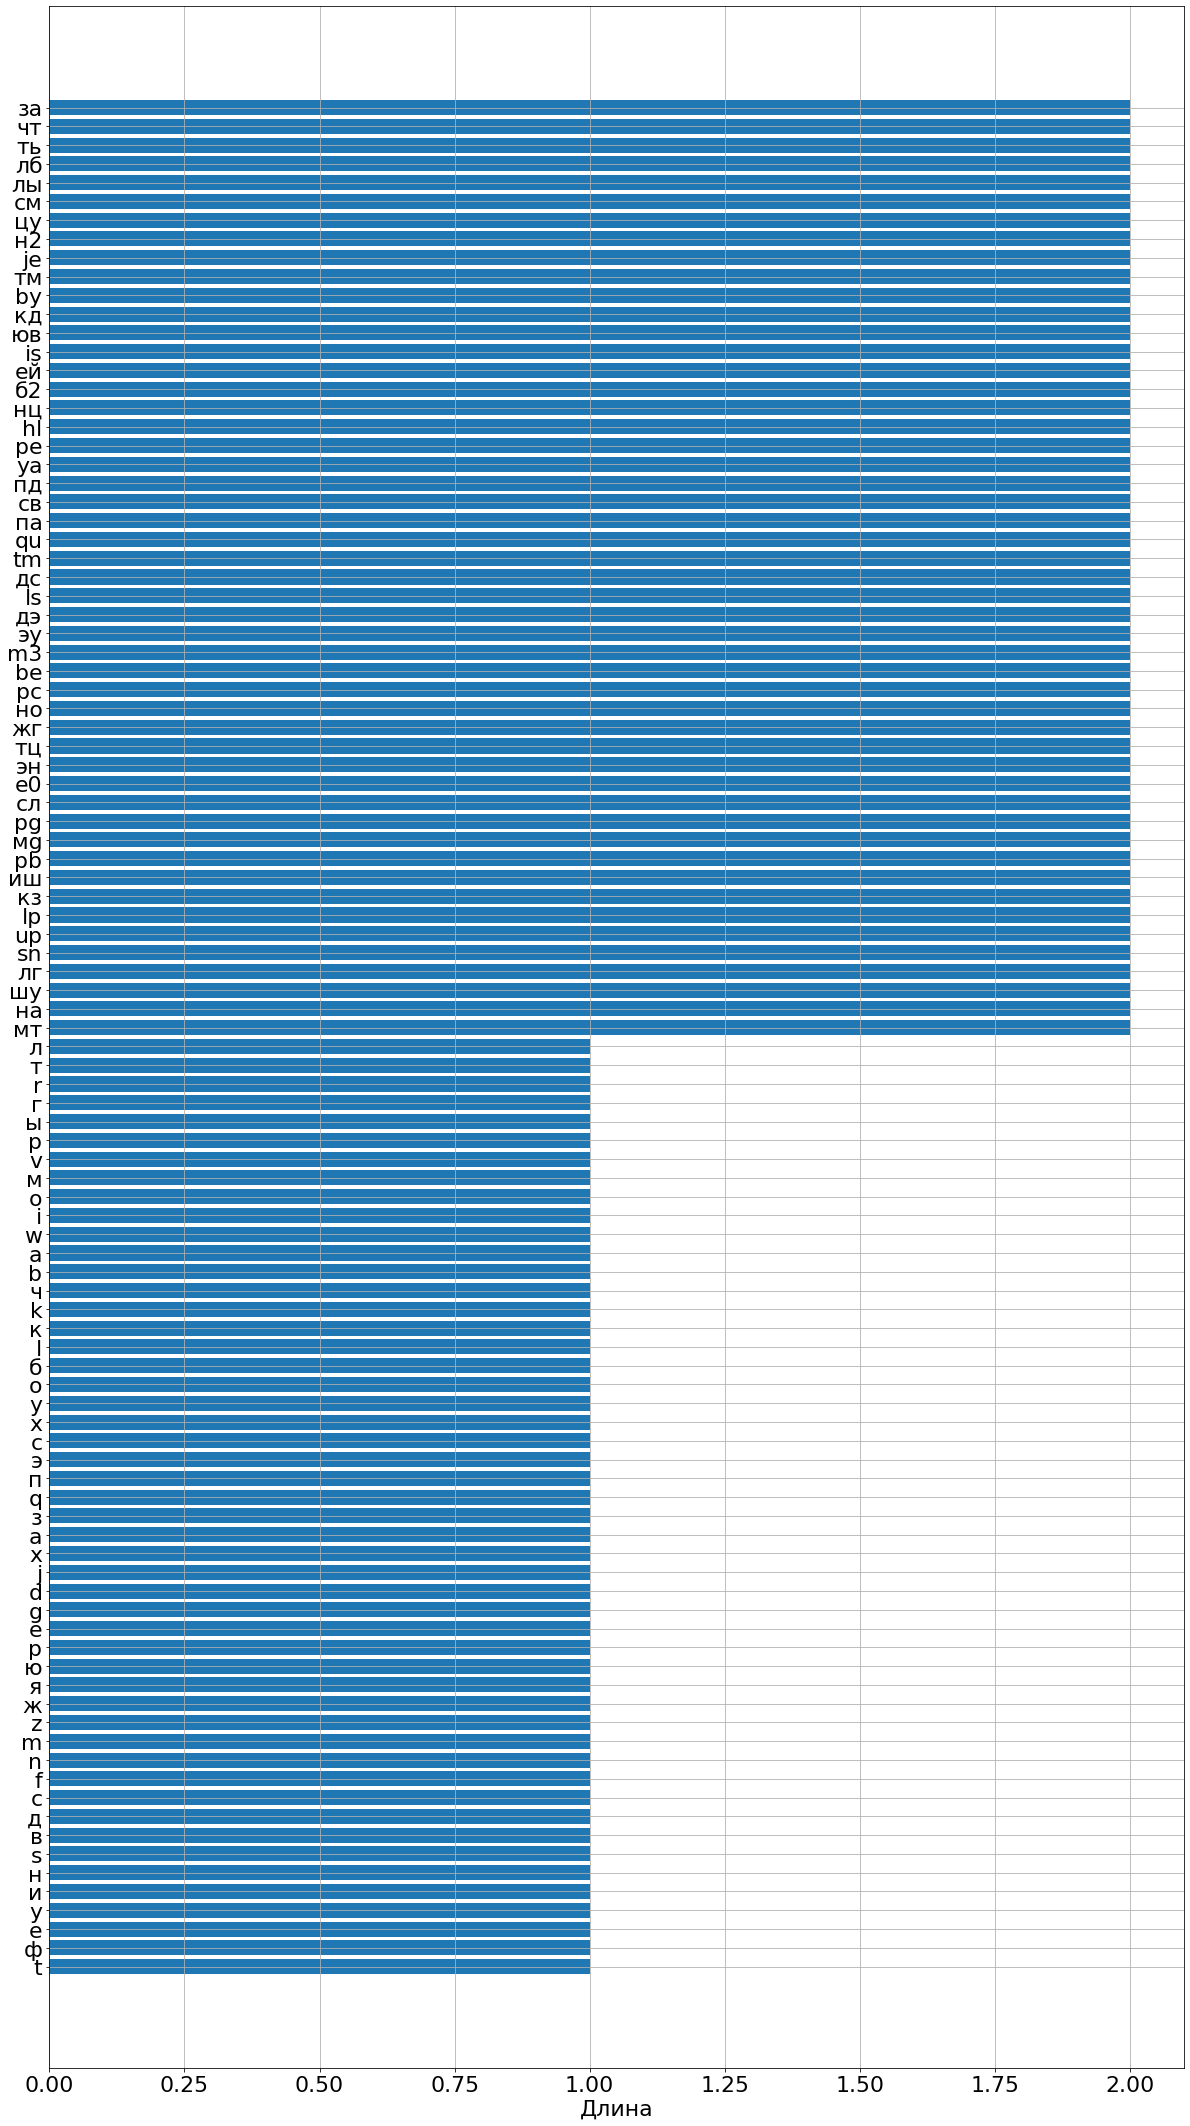

In [141]:
plt.figure(figsize=(17,30))
plt.rcParams.update({'font.size':22})

top_size = 100
word_lengths = sorted({w:len(w) for w in set(words)}.items(), key=lambda x: -x[1])[-top_size:]

plt.barh([x[0] for x in word_lengths][::-1],[x[1] for x in word_lengths][::-1])
plt.xlabel('Длина')
plt.grid()
plt.tight_layout()

## 1.3 - 10 самых частых слов

Найдите 10 самых частых:
* слов
* слов без стоп-слов
* лемм 
* существительных

Топ 10 слов

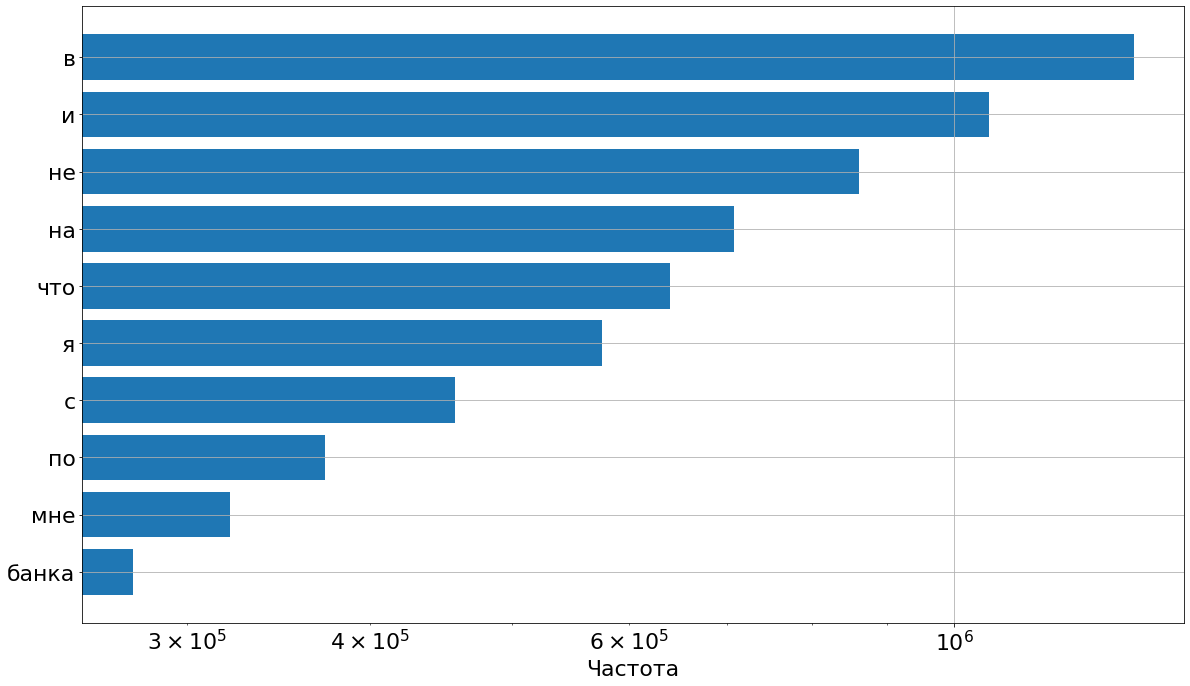

In [144]:
top_size = 10

plt.figure(figsize=(17,top_size))
plt.rcParams.update({'font.size':22})

word_lengths = sorted(Counter(words).items(), key=lambda x: -x[1])[:top_size]

plt.barh([x[0] for x in word_lengths][::-1],[x[1] for x in word_lengths][::-1])
plt.xlabel('Частота')
plt.xscale('log')
plt.grid()
plt.tight_layout()

Без стоп-слов

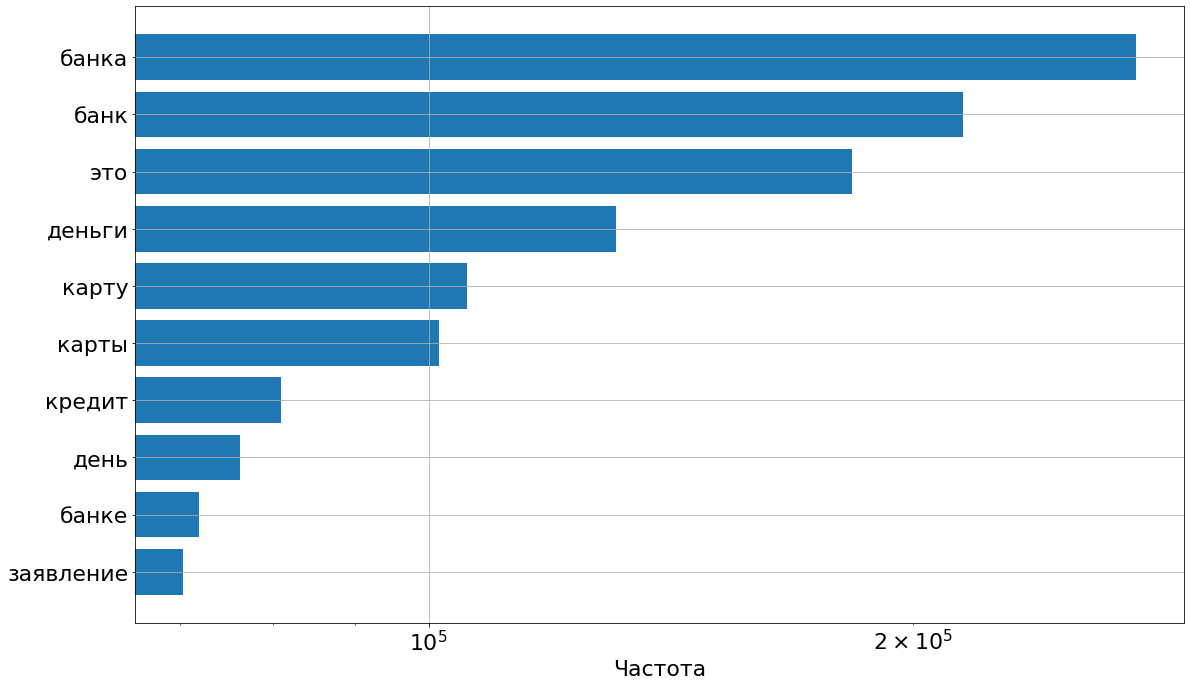

In [145]:
top_size = 10

plt.figure(figsize=(17,top_size))
plt.rcParams.update({'font.size':22})

word_lengths = sorted(Counter([w for w in words if not w.lower() in tokenizer.stop_words]).items(), key=lambda x: -x[1])[:top_size]

plt.barh([x[0] for x in word_lengths][::-1],[x[1] for x in word_lengths][::-1])
plt.xlabel('Частота')
plt.xscale('log')
plt.grid()
plt.tight_layout()

Лемм

In [1]:
# !pip install pymorphy2[fast]

In [176]:
import pymorphy2

def lemmatize(token):
    return pymorphy2.MorphAnalyzer().parse(token)[0].normal_form

lemmas = []
for w in tqdm(np.random.choice(words, 10000)): # иначе ~700 минут будет считаться))
    if not w.lower() in tokenizer.stop_words:
        lemmas.append(lemmatize(w))

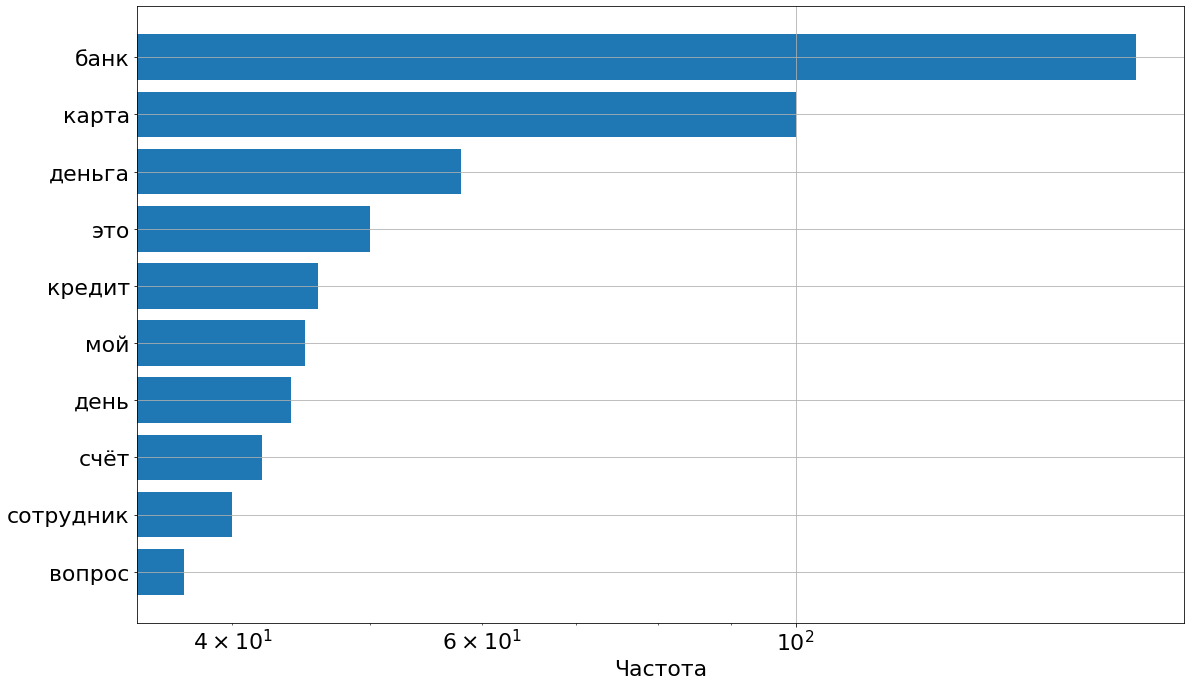

In [177]:
top_size = 10

plt.figure(figsize=(17,top_size))
plt.rcParams.update({'font.size':22})

word_lengths = sorted(Counter(lemmas).items(), key=lambda x: -x[1])[:top_size]

plt.barh([x[0] for x in word_lengths][::-1],[x[1] for x in word_lengths][::-1])
plt.xlabel('Частота')
plt.xscale('log')
plt.grid()
plt.tight_layout()

Существительных

In [201]:
lemmas_nouns = []
for w in tqdm(np.random.choice(words, 10000)): # иначе ~700 минут будет считаться))
    if not w.lower() in tokenizer.stop_words:
        parsed = pymorphy2.MorphAnalyzer().parse(w)[0]
        if parsed.tag.POS == 'NOUN':
            lemmas_nouns.append(lemmatize(parsed.normal_form))

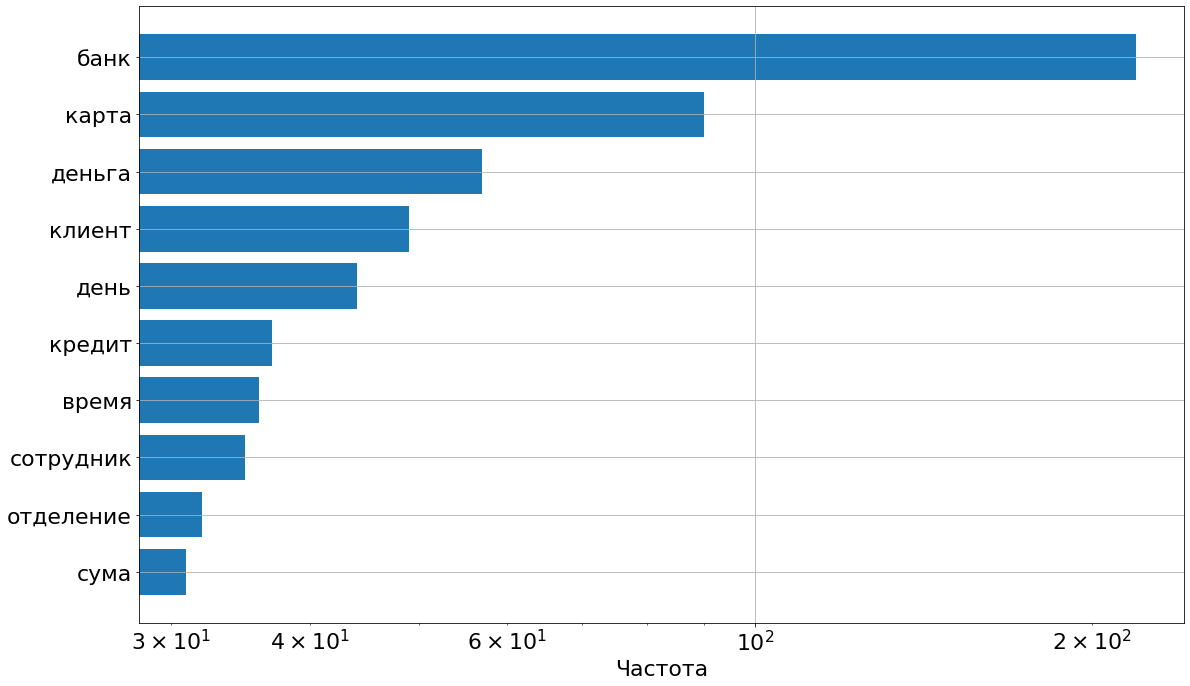

In [202]:
top_size = 10

plt.figure(figsize=(17,top_size))
plt.rcParams.update({'font.size':22})

word_lengths = sorted(Counter(lemmas_nouns).items(), key=lambda x: -x[1])[:top_size]

plt.barh([x[0] for x in word_lengths][::-1],[x[1] for x in word_lengths][::-1])
plt.xlabel('Частота')
plt.xscale('log')
plt.grid()
plt.tight_layout()

## 1.4 - Кривые Ципфа и Хипса
Постройте кривые Ципфа и Хипса

### Кривая Ципфа
Частота n-го слова приблизительно обратно пропорциональна его порядковому номеру (отсортированного по убыванию)

In [238]:
word_stat = sorted(Counter([w for w in words if not w.lower() in tokenizer.stop_words]).items(), key=lambda x: -x[1])

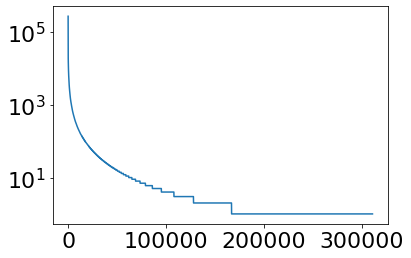

In [248]:
plt.plot([x[1] for x in word_stat])
plt.yscale('log')

На кривую $y=-x$ (в log-шкале) не похоже. Правило не выполняется

### Кривая Хипса
Число уникальных слов $V(n)$ в тексте размера $n$ равно $V(n)=Kn^\beta$. Для английского корпуса текстов $K$ обычно лежит между $10$ и $100$, а $\beta$ между $0,4$ и $0,6$.

In [264]:
unique_words_cnt = []
cumulated_sentence = []
text_sizes = []
for sentence in tqdm(tokens):
    text_sizes.append(len(sentence))
    unique_words_cnt.append(len(set(sentence)))

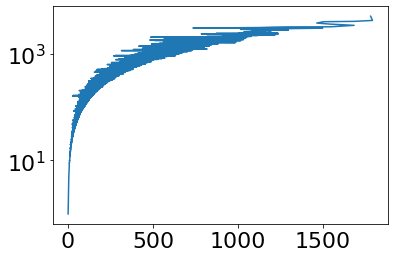

In [265]:
plt.plot(np.array(unique_words_cnt)[np.argsort(text_sizes)], np.array(text_sizes)[np.argsort(text_sizes)])
plt.yscale('log')

На прямую (в логшкале) не похоже. Правило не выполняется

## 1.5 - Частота слов
Ответьте на следующие вопросы:
* какое слово встречается чаще, "сотрудник" или "клиент"?
* сколько раз встречается слова "мошенничество" и "доверие"?

In [221]:
# оценено по подвыборке, результат статзначимый
print('Сотрудник: %d' % dict(word_lengths)['сотрудник'])
print('Клиент: %d' % dict(word_lengths)['клиент'])

Сотрудник: 35
Клиент: 49


In [232]:
print('Мошенничество: %d' % len([w for w in words if w.lower().startswith('мошенничес')])) # стемить весь корпус долго
print('Доверие: %d' % len([w for w in words if w.lower().startswith('довери')]))

Мошенничество: 0
Доверие: 3328


### Уберём стоп-слова

In [36]:
tokenizer = RussianTokenizer(process=True, remove_stop_words=True, stem=True)
    
tokenized_sentences = []
for resp in tqdm(responses):
    tokenized_sentences.append(tokenizer.tokenize(resp['text']))

## 1.6 - Ключевые слова
В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [37]:
positive_responses = [' '.join(tokenized_sentences[i]) for i,r in enumerate(responses) if r['rating_grade'] == 5]
negative_responses = [' '.join(tokenized_sentences[i]) for i,r in enumerate(responses) if r['rating_grade'] == 1]

In [38]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

import pandas as pd
cv = CountVectorizer()
word_count_vector = cv.fit_transform(positive_responses)
tfidf_transformer = TfidfTransformer()
X = tfidf_transformer.fit_transform(word_count_vector)
tf_idf = pd.DataFrame(X.toarray() ,columns=cv.get_feature_names())
tf_idf

,a103,a112233,a4,a851,abalmasik,abatishchev,abdrahmanov,abel,abs,absolut,...,яузок,яхта,яхтеный,яценко,ячейка,ячечный,яшин,яшкова,ящик,ящичек
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14708,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14709,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14710,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14711,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
tf_idfs = tf_idf.mean()

### Топ слова из положительных отзывов

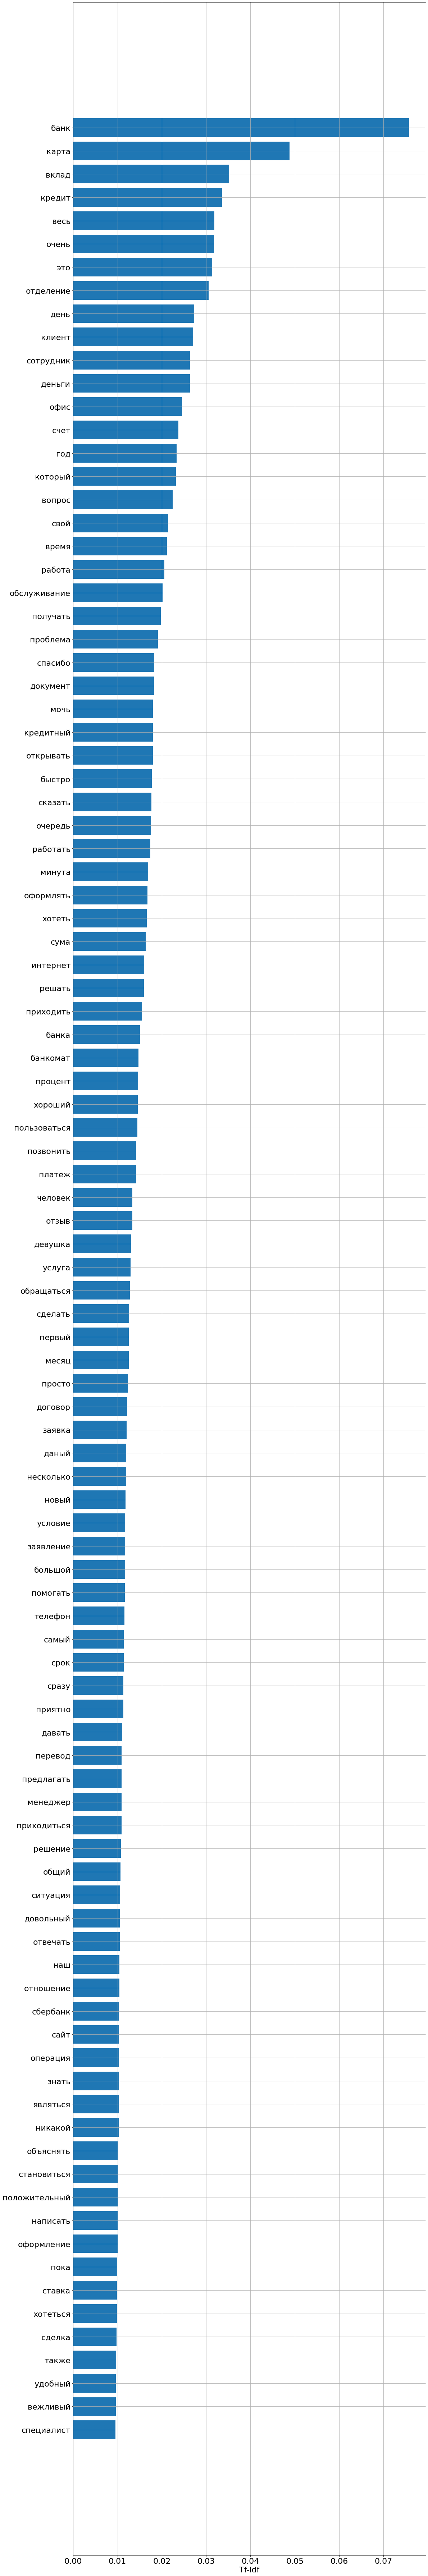

In [40]:
top_size = 100
plt.figure(figsize=(17,top_size))
plt.rcParams.update({'font.size':22})
tf_idfs.sort_values(ascending=False, inplace=True)
plt.barh(tf_idfs[:top_size].index[::-1], tf_idfs[:top_size].values[::-1])
plt.xlabel('Tf-Idf')
plt.grid()
plt.tight_layout()

### Топ слова из отрицательных отзывов

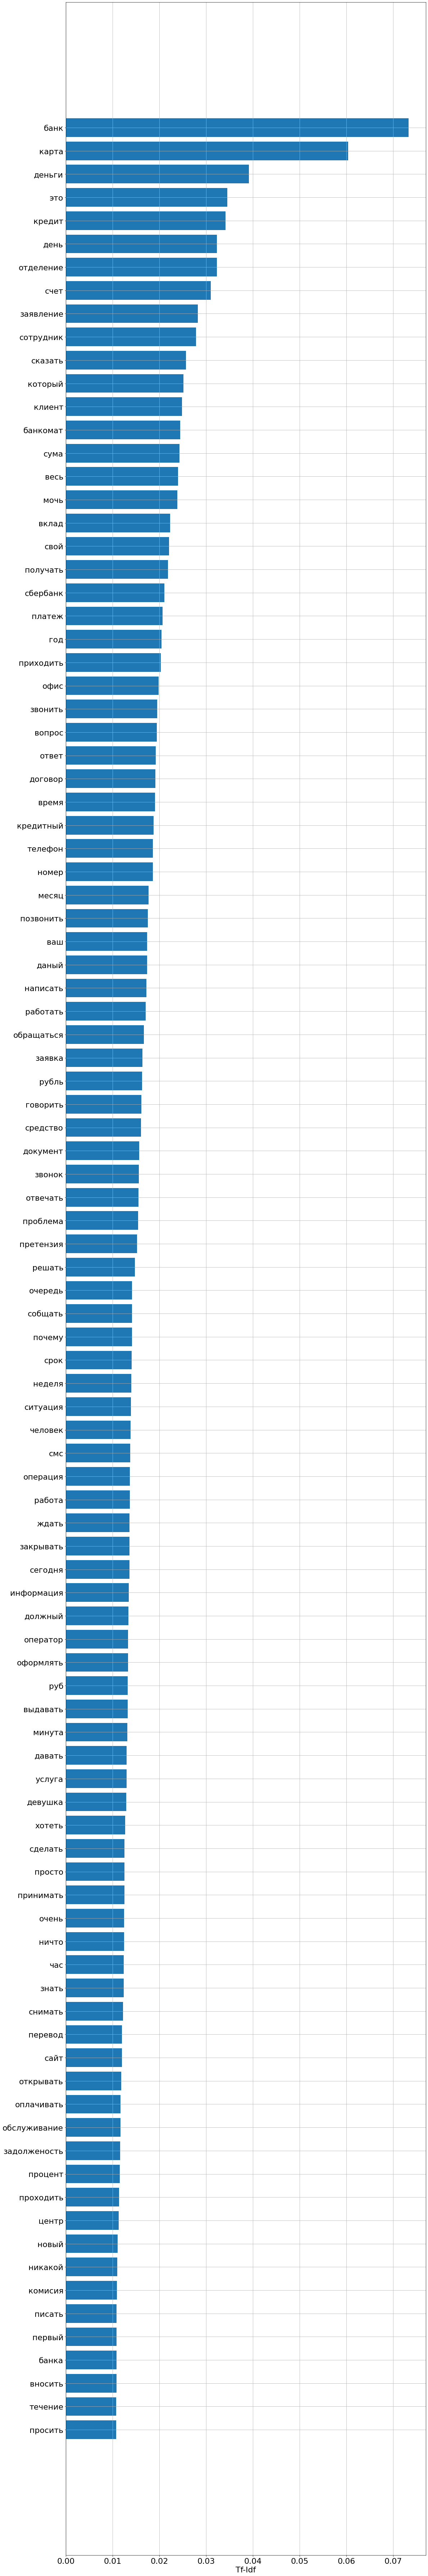

In [41]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

import pandas as pd
cv = CountVectorizer()
word_count_vector = cv.fit_transform(negative_responses)
tfidf_transformer = TfidfTransformer()
X = tfidf_transformer.fit_transform(word_count_vector)
tf_idf = pd.DataFrame(X.toarray() ,columns=cv.get_feature_names())
tf_idfs = tf_idf.mean()
top_size = 100
plt.figure(figsize=(17,top_size))
plt.rcParams.update({'font.size':22})
tf_idfs.sort_values(ascending=False, inplace=True)
plt.barh(tf_idfs[:top_size].index[::-1], tf_idfs[:top_size].values[::-1])
plt.xlabel('Tf-Idf')
plt.grid()
plt.tight_layout()

## Часть 2. Тематическое моделирование [20/100]

1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.
2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?

Эта часть задания может быть сделана с использованием gensim. 

## 2.1

Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.

In [42]:
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.corpora import Dictionary

dictionary = Dictionary(tokens)
corpus = [dictionary.doc2bow(text) for text in tokenized_sentences]

In [48]:
models = [
    LsiModel(corpus=corpus, num_topics=10, id2word=dictionary),
    LsiModel(corpus=corpus, num_topics=50, id2word=dictionary),
    LdaModel(corpus=corpus, num_topics=10, id2word=dictionary),
    HdpModel(corpus=corpus, id2word=dictionary),
         ]

topics = [model.show_topics(formatted=True) for model in models]

In [50]:
for topic in topics: 
    print('******************************************')
    for t in topic:
        print(t[1])

******************************************
0.573*"банк" + 0.328*"карта" + 0.217*"это" + 0.145*"деньги" + 0.144*"день" + 0.143*"который" + 0.135*"счет" + 0.133*"весь" + 0.128*"кредит" + 0.123*"клиент"
0.830*"карта" + -0.370*"банк" + -0.250*"кредит" + -0.110*"договор" + 0.091*"сбербанк" + 0.078*"отделение" + -0.071*"платеж" + -0.069*"сума" + -0.059*"документ" + 0.058*"банкомат"
-0.622*"банк" + -0.261*"карта" + 0.258*"деньги" + 0.203*"это" + 0.197*"отделение" + 0.193*"сбербанк" + 0.175*"день" + 0.157*"сказать" + 0.147*"кредит" + 0.112*"мочь"
0.596*"кредит" + -0.330*"деньги" + -0.255*"вклад" + 0.236*"кредитный" + 0.219*"карта" + -0.211*"счет" + -0.149*"банк" + -0.141*"банкомат" + 0.138*"сума" + 0.138*"договор"
-0.452*"счет" + -0.335*"деньги" + -0.288*"сума" + -0.204*"средство" + 0.187*"это" + -0.163*"платеж" + 0.157*"клиент" + -0.152*"заявление" + -0.147*"рубль" + 0.146*"отделение"
-0.309*"заявление" + 0.283*"деньги" + -0.252*"сотрудник" + 0.247*"кредит" + -0.240*"сбербанк" + -0.236*"отдел

## 2.2
Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?

* **Бинбанк** $0.003*банк + 0.001*клиент + 0.001*карта + 0.001*кредит + 0.001*даный + 0.001*день + 0.001*деньги + 0.001*сотрудник + 0.001*это + 0.001*бинбанк + 0.001*очень + 0.001*платеж + 0.001*ответ + 0.001*весь + 0.001*год + 0.001*который + 0.001*свой + 0.001*сума + 0.001*дверь + 0.001*банкомат$ - судя по всему, топик посвящен получению кредитной карты
* **Метробанк** $0.003*банк + 0.001*вклад + 0.001*карта + 0.001*отделение + 0.001*заявление + 0.001*мочь + 0.001*процент + 0.001*ао + 0.001*метробанк + 0.001*ответ + 0.001*клиент + 0.001*весь + 0.001*сума + 0.001*договор + 0.001*деньги + 0.001*счет + 0.001*год + 0.000*сотрудник + 0.000*свой + 0.000*время$ - топик посвящен вкладам
* **Сбербанк** $0.830*"карта" + -0.370*"банк" + -0.250*"кредит" + -0.110*"договор" + 0.091*"сбербанк" + 0.078*"отделение" + -0.071*"платеж" + -0.069*"сума" + -0.059*"документ" + 0.058*"банкомат"$ - топик посвящен снятию с карты, судя по всему

## Часть 3. Классификация текстов [40/100]

Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5). 

1.  Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте ```sklearn.model_selection.train_test_split``` для разделения множества отобранных документов на обучающее и тестовое. 
2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных $n$-грам. 
3. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
* 1-ый вариант: $tf-idf$ преобразование (```sklearn.feature_extraction.text.TfidfTransformer```) и сингулярное разложение (оно же – латентый семантический анализ) (```sklearn.decomposition.TruncatedSVD```), 
* 2-ой вариант: тематические модели LDA (```sklearn.decomposition.LatentDirichletAllocation```). 

Используйте accuracy и F-measure для оценки качества классификации. 

Ниже написан примерный Pipeline для классификации текстов. 

Эта часть задания может быть сделана с использованием sklearn. 

In [56]:
data = negative_responses + positive_responses
labels = np.concatenate([np.zeros(len(negative_responses)),
                       np.ones(len(positive_responses))])
len(data), labels.shape

(62100, (62100,))

In [58]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels, train_size=0.9, shuffle=True)

In [63]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

# !!! На каждом этапе Pipeline нужно указать свои параметры
# 1-ый вариант: tf-idf + LSI
# 2-ой вариант: LDA

clf = Pipeline([
    ('vect', CountVectorizer()), 
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier()),
])


clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred), f1_score(y_test, y_pred)

(0.9011272141706924, 0.7460711331679073)

In [66]:
from sklearn.decomposition import TruncatedSVD

n_topics = 10

clf = Pipeline([ 
    ('vect', CountVectorizer()), 
    ('tfidf', TfidfTransformer()), 
    ('tm', TruncatedSVD(n_components=n_topics)), 
    ('clf', RandomForestClassifier())
])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred), f1_score(y_test, y_pred)

(0.8869565217391304, 0.7358916478555306)

In [64]:
from sklearn.decomposition import TruncatedSVD

n_topics = 50

clf = Pipeline([ 
    ('vect', CountVectorizer()), 
    ('tfidf', TfidfTransformer()), 
    ('tm', TruncatedSVD(n_components=n_topics)), 
    ('clf', RandomForestClassifier())
])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred), f1_score(y_test, y_pred)

(0.9093397745571659, 0.7803355442840422)

In [65]:
from sklearn.decomposition import TruncatedSVD

n_topics = 200

clf = Pipeline([ 
    ('vect', CountVectorizer()), 
    ('tfidf', TfidfTransformer()), 
    ('tm', TruncatedSVD(n_components=n_topics)), 
    ('clf', RandomForestClassifier())
])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred), f1_score(y_test, y_pred)

(0.8913043478260869, 0.718397997496871)

### Вывод
При правильном выборе числа топиков качество классификации существенно вырастает как по Accuracy, так и по F1